In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import gpflow
from gpflow.test_util import notebook_niter, is_continuous_integration
from scipy.cluster.vq import kmeans2

float_type = gpflow.settings.float_type 

ITERATIONS = notebook_niter(1000)

# Mixing tensorflow models with gpflow


### Example 1: a convnet inside a gpflow model
Here we'll use the gpflow functionality, but we'll put a non-gpflow model inside the kernel

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data/MNIST_data/", one_hot=False)

class Mnist:
    input_dim = 784
    Nclasses = 10
    X = mnist.train.images.astype(float)
    Y = mnist.train.labels.astype(float)[:, None]
    Xtest = mnist.test.images.astype(float)
    Ytest = mnist.test.labels.astype(float)[:, None]

if is_continuous_integration():
    mask = (Mnist.Y <= 1).squeeze()
    Mnist.X = Mnist.X[mask][:105, 300:305]
    Mnist.Y = Mnist.Y[mask][:105]
    mask = (Mnist.Ytest <= 1).squeeze()
    Mnist.Xtest = Mnist.Xtest[mask][:10, 300:305]
    Mnist.Ytest = Mnist.Ytest[mask][:10]
    Mnist.input_dim = 5
    Mnist.Nclasses = 2

In [3]:
# a vanilla conv net
# this gets 97.3% accuracy on MNIST when used on its own (+ final linear layer) after 20K iterations
def cnn_fn(x, output_dim):
    """
    Adapted from https://www.tensorflow.org/tutorials/layers
    """
    conv1 = tf.layers.conv2d(
          inputs=tf.reshape(x, [-1, 28, 28, 1]),
          filters=32,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    return tf.layers.dense(inputs=pool2_flat, units=output_dim, activation=tf.nn.relu)

if is_continuous_integration():
    def cnn_fn(x, output_dim):
        return tf.layers.dense(inputs=tf.reshape(x, [-1, Mnist.input_dim]), units=output_dim)

In [4]:
class KernelWithNN(gpflow.kernels.Kernel):
    """
    This kernel class allows for easily adding a NN (or other function) to a GP model.
    The kernel does not actually do anything with the NN.
    """
    
    def __init__(self, kern, f):
        """
        kern.input_dim needs to be consistent with the output dimension of f
        """
        super().__init__(kern.input_dim)
        self.kern = kern
        self._f = f
        
    def f(self, X):
        if X is not None:
            with tf.variable_scope('forward', reuse=tf.AUTO_REUSE):
                return self._f(X)
    
    def _get_f_vars(self):
        return tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='forward')

    @gpflow.autoflow([gpflow.settings.float_type, [None,None]])
    def compute_f(self, X):
        return self.f(X)
    
    def K(self, X, X2=None):
        return self.kern.K(X, X2)
    
    def Kdiag(self, X):
        return self.kern.Kdiag(X)

class KernelSpaceInducingPoints(gpflow.features.InducingPointsBase):
    pass

# same Kuu as regular inducing points
gpflow.features.Kuu.register(KernelSpaceInducingPoints, KernelWithNN)(
    gpflow.features.Kuu.dispatch(gpflow.features.InducingPoints, gpflow.kernels.Kernel)
)

# Kuf is in NN output space
@gpflow.features.dispatch(KernelSpaceInducingPoints, KernelWithNN, object)
def Kuf(feat, kern, Xnew):
    with gpflow.params_as_tensors_for(feat):
        return kern.K(feat.Z, kern.f(Xnew))

class NNComposedKernel(KernelWithNN):
    """
    This kernel class applies f() to X before calculating K
    """
    
    def K(self, X, X2=None):
        return super().K(self.f(X), self.f(X2))
    
    def Kdiag(self, X):
        return super().Kdiag(self.f(X))
    
# we need to add these extra functions to the model so the tensorflow variables get picked up
class NN_SVGP(gpflow.models.SVGP):
    @property
    def trainable_tensors(self):
        return super().trainable_tensors + self.kern._get_f_vars()

    @property
    def initializables(self):
        return super().initializables + self.kern._get_f_vars()
    

In [5]:
def ex1():
    fX_dim = 5  
    M = 100

    # annoyingly only float32 and lower is supported by the conv layers 
    f = lambda x: tf.cast(cnn_fn(tf.cast(x, tf.float32), fX_dim), float_type)
    kern = NNComposedKernel(gpflow.kernels.Matern32(fX_dim), f)

    # build the model 

    lik = gpflow.likelihoods.MultiClass(Mnist.Nclasses)

    Z = kmeans2(Mnist.X, M, minit='points')[0]

    model = NN_SVGP(Mnist.X, Mnist.Y, kern, lik, Z=Z, num_latent=Mnist.Nclasses, minibatch_size=1000)

    # use gpflow wrappers to train. NB all session handling is done for us
    gpflow.training.AdamOptimizer(0.001).minimize(model, maxiter=ITERATIONS)

    # predictions
    m, v = model.predict_y(Mnist.Xtest)
    preds = np.argmax(m, 1).reshape(Mnist.Ytest.shape)
    correct = preds == Mnist.Ytest.astype(int)
    acc = np.average(correct.astype(float)) * 100.

    print('accuracy is {:.4f}%'.format(acc))

gpflow.reset_default_graph_and_session()
ex1()

accuracy is 98.6800%


In [6]:
def ex2b():
    fX_dim = 5  
    minibatch_size = notebook_niter(1000, test_n=10)
    M = notebook_niter(100, test_n=5)

    # annoyingly only float32 and lower is supported by the conv layers 
    f = lambda x: tf.cast(cnn_fn(tf.cast(x, tf.float32), fX_dim), float_type)
    kern = KernelWithNN(gpflow.kernels.Matern32(fX_dim), f)
    
    ## reset inducing (they live in a different space as X, so need to be careful with this)
    ind = np.random.choice(Mnist.X.shape[0], minibatch_size, replace=False)
    
    # currently we need a hack due to model initialization.
    feat = KernelSpaceInducingPoints(np.empty((M, fX_dim)))
    #feat = FFeature(Z_0)  # ideally, we could move the calculation of Z_0
    
    # build the model 

    lik = gpflow.likelihoods.MultiClass(Mnist.Nclasses)

    #Z = kmeans2(Mnist.X, M, minit='points')[0]

    model = NN_SVGP(Mnist.X, Mnist.Y, kern, lik, feat=feat, num_latent=Mnist.Nclasses, minibatch_size=minibatch_size)

    fZ = model.kern.compute_f(Mnist.X[ind])
    # Z_0 = kmeans2(fZ, M)[0] might fail
    Z_0 = fZ[np.random.choice(len(fZ), M, replace=False)]
    model.feature.Z = Z_0

    # use gpflow wrappers to train. NB all session handling is done for us
    gpflow.training.AdamOptimizer(0.001).minimize(model, maxiter=ITERATIONS)

    # predictions
    m, v = model.predict_y(Mnist.Xtest)
    preds = np.argmax(m, 1).reshape(Mnist.Ytest.shape)
    correct = preds == Mnist.Ytest.astype(int)
    acc = np.average(correct.astype(float)) * 100.

    print('accuracy is {:.4f}%'.format(acc))

gpflow.reset_default_graph_and_session()
ex2b()

accuracy is 97.5600%


### Example 2: a gpflow model on top of a tensorflow model
Now we'll do things the other way: we'll take a model implemented in pure tensorflow, and show how we can put a gpflow model on the top

In [7]:
def ex2():
    minibatch_size = notebook_niter(1000, test_n=10)
    gp_dim = 5
    M = notebook_niter(100, test_n=5)

    ## placeholders
    X = tf.placeholder(tf.float32, [minibatch_size, Mnist.input_dim])  # fixed shape so num_data works in SVGP
    Y = tf.placeholder(tf.float32, [minibatch_size, 1])
    Xtest = tf.placeholder(tf.float32, [None, Mnist.input_dim])

    ## build graph

    with tf.variable_scope('cnn'):
        f_X = tf.cast(cnn_fn(X, gp_dim), dtype=float_type)

    with tf.variable_scope('cnn', reuse=True):
        f_Xtest = tf.cast(cnn_fn(Xtest, gp_dim), dtype=float_type)

    gp_model = gpflow.models.SVGP(f_X, tf.cast(Y, dtype=float_type), 
                                  gpflow.kernels.RBF(gp_dim), gpflow.likelihoods.MultiClass(Mnist.Nclasses), 
                                  Z=np.zeros((M, gp_dim)), # we'll set this later
                                  num_latent=Mnist.Nclasses)

    loss = -gp_model.likelihood_tensor

    m, v = gp_model._build_predict(f_Xtest)
    my, yv = gp_model.likelihood.predict_mean_and_var(m, v)

    with tf.variable_scope('adam'):
        opt_step = tf.train.AdamOptimizer(0.001).minimize(loss)

    tf_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='adam')
    tf_vars += tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='cnn')

    ## initialize
    sess = tf.Session()
    sess.run(tf.variables_initializer(var_list=tf_vars))
    gp_model.initialize(session=sess)
    
    ## reset inducing (they live in a different space as X, so need to be careful with this)
    ind = np.random.choice(Mnist.X.shape[0], minibatch_size, replace=False)

    fZ = sess.run(f_X, feed_dict={X:Mnist.X[ind]})
    # Z_0 = kmeans2(fZ, M)[0] might fail
    Z_0 = fZ[np.random.choice(len(fZ), M, replace=False)]

    def set_gp_param(param, value):
        sess.run(tf.assign(param.unconstrained_tensor, param.transform.backward(value)))

    set_gp_param(gp_model.feature.Z, Z_0)

    ## train
    for i in range(ITERATIONS):
        ind = np.random.choice(Mnist.X.shape[0], minibatch_size, replace=False)
        sess.run(opt_step, feed_dict={X:Mnist.X[ind], Y:Mnist.Y[ind]})

    ## predict
    preds = np.argmax(sess.run(my, feed_dict={Xtest:Mnist.Xtest}), 1).reshape(Mnist.Ytest.shape)
    correct = preds == Mnist.Ytest.astype(int)
    acc = np.average(correct.astype(float)) * 100.
    print('acc is {:.4f}'.format(acc))

gpflow.reset_default_graph_and_session()
ex2()

gpflow.reset_default_graph_and_session()

acc is 98.5900


# Using feed dicts with autoflow

We'll recreate something like Fig 5.5 from GPML, which is a plot of the marginal likelihood against hyperparameter configurations. We want to loop over a grid of hyperparameters, but it turns out gpflow can be very slow to do this using assign. We can get around this using a feed dict with autoflow. 


In [8]:
X = np.array((-6, -4, -2.1, -2, 2, 5.5, 6)).reshape(-1, 1)
Y = np.array((-0.5, -0.5, 1.7, 1.6, 1, 2, 1.9)).reshape(-1, 1)

model = gpflow.models.GPR(X, Y, gpflow.kernels.RBF(1))

In [9]:
%%timeit
# this is how long it takes to do the calculation with fixed parameters
model.compute_log_likelihood()
pass

1.78 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
%%timeit
# the assign method
model.kern.lengthscales = 1.
model.likelihood.variance = 0.1
model.compute_log_likelihood()

100 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
def make_feed(param, value):
    return {param.unconstrained_tensor : param.transform.backward(value)}

In [12]:
%%timeit
# the feed dict method
feed_dict = {}
feed_dict.update(make_feed(model.kern.lengthscales, 1.))
feed_dict.update(make_feed(model.likelihood.variance, 0.1))
model.compute_log_likelihood(feed_dict=feed_dict)

1.64 ms ± 25.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
def evaluate(func, param_feed_dict):
    tensor_feed_dict = {}
    for param, value in param_feed_dict.items():
        tensor_feed_dict.update(make_feed(param, value))
    return func(feed_dict=tensor_feed_dict)

In [14]:
%%timeit
evaluate(model.compute_log_likelihood, {model.kern.lengthscales: 1., model.likelihood.variance: 0.1})

1.66 ms ± 50.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


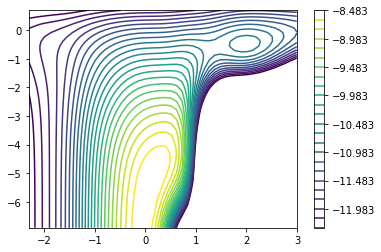

In [15]:
# with the feed dict method this example is feasible

log_noises = np.linspace(np.log(0.001), np.log(2.), 50)
log_lengthscales = np.linspace(np.log(0.1), np.log(20), 50)

xx, yy = np.meshgrid(log_lengthscales, log_noises)
zz = []

for lengthscale, noise in zip(np.exp(xx.flatten()), np.exp(yy.flatten())):
    feed_dict = {}
    feed_dict.update(make_feed(model.kern.lengthscales, lengthscale))
    feed_dict.update(make_feed(model.likelihood.variance, noise))
    # adapt GPflow so that we can use the following instead:
    #zz.append(model.evaluate(model.compute_log_likelihood,
    #                         {model.kern.lengthscales: lengthscale,
    #                          model.likelihood.variance: noise}
    #                        ))
    # to pass arguments e.g. for predict_f(XX), could use
    # model.evaluate(functools.partial(model.predict_f, XX), {...: ..., ...})
    zz.append(model.compute_log_likelihood(feed_dict=feed_dict))
    
plt.contour(xx, yy, np.array(zz).reshape(xx.shape),
           levels = np.linspace(np.max(zz)-4, np.max(zz), 25))
plt.colorbar()
plt.show()

    